In [1]:
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import gaussian_kde

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.verification import load_tganom_and_compute, load_tgex_and_compute, build_fit_nn_model, compute_bss, compute_kss, compute_auc, reduce_to_ranks, reduce_to_skill

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import reliability_plot

2022-01-06 13:16:00.126861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 13:16:00.126883: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Investigation of most successful prediction
(When going through the standard objective predictor selection).

In [70]:
name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
total, test_only = build_fit_nn_model(predictandname = name, npreds = 4, use_jmeasure=False)
trainval_only = total.drop(test_only.index, axis = 0)

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.7215 - accuracy: 0.5544 - brier: 0.2575 - val_loss: 0.7743 - val_accuracy: 0.5016 - val_brier: 0.2845
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6819 - accuracy: 0.6081 - brier: 0.2391 - val_loss: 0.7404 - val_accuracy: 0.4953 - val_brier: 0.2700
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6318 - accuracy: 0.6680 - brier: 0.2156 - val_loss: 0.7084 - val_accuracy: 0.5363 - val_brier: 0.2561
Epoch 4/200
41/41 [==============================] - 0s 991us/step - loss: 0.5949 - accuracy: 0.7100 - brier: 0.1989 - val_loss: 0.6861 - val_accuracy: 0.5789 - val_brier: 0.2463
Epoch 5/200
41/41 [==============================] - 0s 995us/step - loss: 0.5763 - accuracy: 0.7255 - brier: 0.1902 - val_loss: 0.6692 - val_accuracy: 0.5883 - val_brier: 0.2392
Epoch 6/200
41/41 [=============================

In [32]:
n_iter = 2000
bs = pd.DataFrame(np.nan, columns = pd.MultiIndex.from_product([['trainval','test'],test_only.columns[test_only.columns.str.endswith('_bs')]], names = ['set','forecast']), index = pd.RangeIndex(n_iter))
for i in range(n_iter):

    trainval_sample = np.random.randint(low = 0, high = trainval_only.shape[0], size = trainval_only.shape[0]) # bootstrap sample with replacement.
    test_sample = np.random.randint(low = 0, high = test_only.shape[0], size = test_only.shape[0])
    
    for forecast_key in bs.columns.get_level_values('forecast').unique():
        bs.loc[i,('test',forecast_key)] = test_only[forecast_key].iloc[test_sample.tolist()].mean()
        bs.loc[i,('trainval',forecast_key)] = trainval_only[forecast_key].iloc[trainval_sample.tolist()].mean()

In [35]:
bs.columns

MultiIndex([('trainval',          'pi_bs'),
            ('trainval',        'ppsf_bs'),
            ('trainval', 'climatology_bs'),
            ('trainval',       'trend_bs'),
            (    'test',          'pi_bs'),
            (    'test',        'ppsf_bs'),
            (    'test', 'climatology_bs'),
            (    'test',       'trend_bs')],
           names=['set', 'forecast'])

In [42]:
# scale test and trainval BS separately based on the mean raw score
bszero = bs.copy()
bszero['test'] = bs['test'] - float(bs[('test', 'pi_bs')].mean())
bszero['trainval'] = bs['trainval'] - float(bs[('trainval', 'pi_bs')].mean())

In [43]:
def to_kernel_density(vals):
    if isinstance(vals, (pd.Series, pd.DataFrame)):
        vals = vals.values.squeeze()
    positions = np.linspace(start = vals.min(), stop = vals.max(), num = 100)
    density = gaussian_kde(vals)(positions)
    return(positions, density)

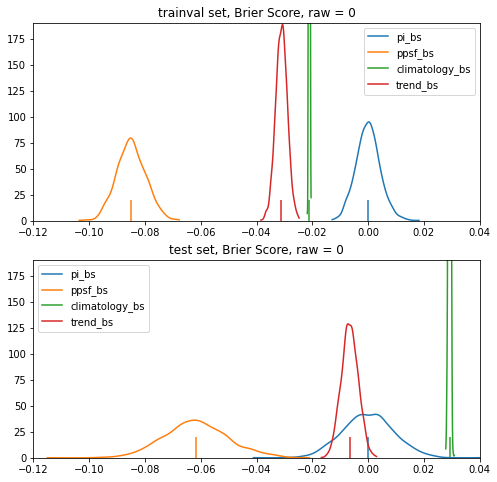

In [46]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.plot(*to_kernel_density(bszero[key]),label = key[-1])
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 20, color = im[0].get_c())
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,190)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

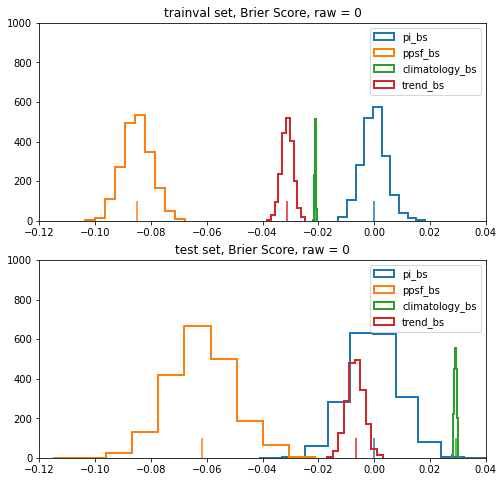

In [58]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.hist(bszero[key], label = key[-1], histtype = 'step', lw = 2)
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 100, color = im[2][0].get_edgecolor())
    #ax.set_xlim(left = -0.12, right = 0.08)
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,1000)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

In [64]:
test_only.columns.name = 'type'
trainval_only.columns.name = 'type'

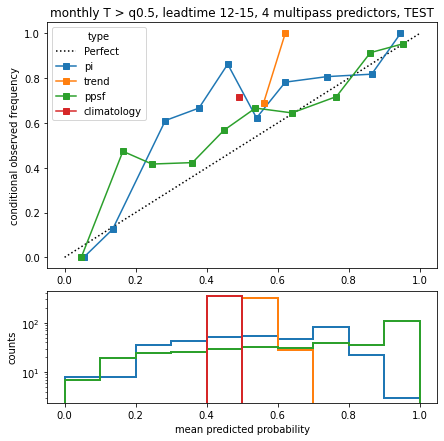

In [63]:
fig, (axrel, axhist) = reliability_plot(y_true = test_only['observation'], y_probs=test_only[['pi', 'trend','ppsf', 'climatology']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TEST')
plt.show()

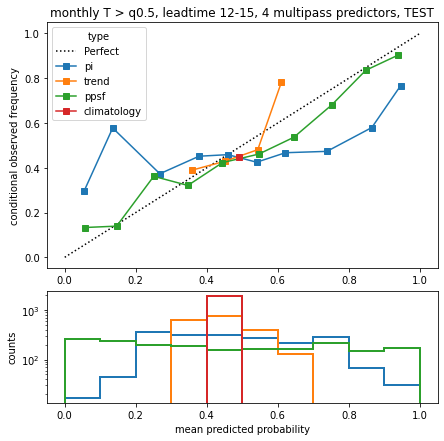

In [65]:
fig, (axrel, axhist) = reliability_plot(y_true = trainval_only['observation'], y_probs=trainval_only[['pi', 'trend','ppsf', 'climatology']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TEST')
plt.show()

## Broad verification
Multiple metrics, thresholds, time scales, lead times. Currently post-processed combinations are not post-processed with jmeasure input.

In [44]:
def extra_scores_and_rank(df):
    compute_kss(df)
    compute_auc(df)
    return reduce_to_skill(df)

In [45]:
# Handle all the tganom post-processed combinations with objective sequential forward predictors.
# We will only look at test data.
timeaggs = [21,31]
quantiles = [0.5, 0.66, 0.75, 0.9]
npreds = pd.Series([4,3,4,6,4,4,4,12], index = pd.MultiIndex.from_product([timeaggs, quantiles], names = ['timeagg','quantile'])) # This is a mixture of >3% >4%
def get_tganom_predictions(timeagg: int, quantile: float):
    name = f'tg-anom_JJA_45r1_{timeagg}D-roll-mean_q{quantile}_sep12-15'
    _, test_only = build_fit_nn_model(predictandname = name, npreds = npreds.loc[(timeagg,quantile)], use_jmeasure=False)
    return test_only
results = []
for timeagg, quantile in npreds.index:
    results.append(extra_scores_and_rank(get_tganom_predictions(timeagg, quantile)))
ranktganom = pd.concat(results, axis = 1, keys = npreds.index).T

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5902 - brier: 0.2507 - val_loss: 0.7405 - val_accuracy: 0.5110 - val_brier: 0.2698
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6866 - accuracy: 0.5988 - brier: 0.2427 - val_loss: 0.7121 - val_accuracy: 0.5379 - val_brier: 0.2582
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6538 - accuracy: 0.6454 - brier: 0.2284 - val_loss: 0.6677 - val_accuracy: 0.5741 - val_brier: 0.2396
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6245 - accuracy: 0.6804 - brier: 0.2155 - val_loss: 0.6376 - val_accuracy: 0.6041 - val_brier: 0.2264
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6034 - accuracy: 0.6804 - brier: 0.2064 - val_loss: 0.6209 - val_accuracy: 0.6246 - val_brier: 0.2188
Epoch 6/200
41/41 [==============================] -

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.5812 - accuracy: 0.7278 - brier: 0.1936 - val_loss: 0.7025 - val_accuracy: 0.6246 - val_brier: 0.2450
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5694 - accuracy: 0.7341 - brier: 0.1882 - val_loss: 0.6877 - val_accuracy: 0.6309 - val_brier: 0.2387
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5500 - accuracy: 0.7558 - brier: 0.1800 - val_loss: 0.6609 - val_accuracy: 0.6404 - val_brier: 0.2291
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5299 - accuracy: 0.7652 - brier: 0.1718 - val_loss: 0.6401 - val_accuracy: 0.6751 - val_brier: 0.2202
Epoch 5/200
41/41 [==============================] - 0s 984us/step - loss: 0.5173 - accuracy: 0.7714 - brier: 0.1662 - val_loss: 0.6354 - val_accuracy: 0.6893 - val_brier: 0.2164
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5063 - accuracy: 0.7784 - brier: 0.1607 - val_loss

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.4553 - accuracy: 0.8103 - brier: 0.1441 - val_loss: 0.6208 - val_accuracy: 0.7256 - val_brier: 0.2035
Epoch 2/200
41/41 [==============================] - 0s 995us/step - loss: 0.4374 - accuracy: 0.8188 - brier: 0.1371 - val_loss: 0.6093 - val_accuracy: 0.7319 - val_brier: 0.2018
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4131 - accuracy: 0.8274 - brier: 0.1286 - val_loss: 0.5853 - val_accuracy: 0.7445 - val_brier: 0.1912
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3831 - accuracy: 0.8320 - brier: 0.1180 - val_loss: 0.5642 - val_accuracy: 0.7555 - val_brier: 0.1853
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3595 - accuracy: 0.8421 - brier: 0.1091 - val_loss: 0.5532 - val_accuracy: 0.7634 - val_brier: 0.1799
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3434 - accuracy: 0.8546 - brier: 0.1033 - val_loss

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.2640 - accuracy: 0.9176 - brier: 0.0713 - val_loss: 0.2942 - val_accuracy: 0.9196 - val_brier: 0.0761
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2572 - accuracy: 0.9207 - brier: 0.0697 - val_loss: 0.2919 - val_accuracy: 0.9164 - val_brier: 0.0753
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2516 - accuracy: 0.9207 - brier: 0.0686 - val_loss: 0.2902 - val_accuracy: 0.9164 - val_brier: 0.0749
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2425 - accuracy: 0.9215 - brier: 0.0665 - val_loss: 0.2857 - val_accuracy: 0.9180 - val_brier: 0.0735
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2275 - accuracy: 0.9184 - brier: 0.0628 - val_loss: 0.2769 - val_accuracy: 0.9180 - val_brier: 0.0703
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2150 - accuracy: 0.9207 - brier: 0.0601 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.7213 - accuracy: 0.5622 - brier: 0.2572 - val_loss: 0.7748 - val_accuracy: 0.5126 - val_brier: 0.2847
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.6003 - brier: 0.2422 - val_loss: 0.7505 - val_accuracy: 0.5221 - val_brier: 0.2744
Epoch 3/200
41/41 [==============================] - 0s 999us/step - loss: 0.6464 - accuracy: 0.6563 - brier: 0.2223 - val_loss: 0.7234 - val_accuracy: 0.5331 - val_brier: 0.2627
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6155 - accuracy: 0.7014 - brier: 0.2080 - val_loss: 0.7037 - val_accuracy: 0.5489 - val_brier: 0.2542
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5919 - accuracy: 0.7185 - brier: 0.1969 - val_loss: 0.6817 - val_accuracy: 0.5773 - val_brier: 0.2444
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5744 - accuracy: 0.7240 - brier: 0.1893 - val_loss

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.5560 - accuracy: 0.7341 - brier: 0.1836 - val_loss: 0.7305 - val_accuracy: 0.6388 - val_brier: 0.2518
Epoch 2/200
41/41 [==============================] - 0s 997us/step - loss: 0.5404 - accuracy: 0.7512 - brier: 0.1771 - val_loss: 0.7141 - val_accuracy: 0.6467 - val_brier: 0.2453
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5184 - accuracy: 0.7566 - brier: 0.1693 - val_loss: 0.7004 - val_accuracy: 0.6703 - val_brier: 0.2390
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5002 - accuracy: 0.7605 - brier: 0.1627 - val_loss: 0.6856 - val_accuracy: 0.6625 - val_brier: 0.2347
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4896 - accuracy: 0.7683 - brier: 0.1594 - val_loss: 0.6800 - val_accuracy: 0.6767 - val_brier: 0.2292
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4767 - accuracy: 0.7737 - brier: 0.1544 - val_loss

41/41 [==============================] - 0s 1ms/step - loss: 0.3738 - accuracy: 0.8476 - brier: 0.1153 - val_loss: 0.5356 - val_accuracy: 0.7413 - val_brier: 0.1789
Epoch 48/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3727 - accuracy: 0.8484 - brier: 0.1152 - val_loss: 0.5176 - val_accuracy: 0.7382 - val_brier: 0.1725
Epoch 49/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3719 - accuracy: 0.8507 - brier: 0.1147 - val_loss: 0.5284 - val_accuracy: 0.7397 - val_brier: 0.1763
Epoch 50/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3739 - accuracy: 0.8445 - brier: 0.1151 - val_loss: 0.5311 - val_accuracy: 0.7397 - val_brier: 0.1773
Epoch 51/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3723 - accuracy: 0.8468 - brier: 0.1149 - val_loss: 0.5200 - val_accuracy: 0.7429 - val_brier: 0.1734
Epoch 52/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3713 - accuracy: 0.8491 - brier: 0.1144 - val_l

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.4255 - accuracy: 0.8281 - brier: 0.1318 - val_loss: 0.6254 - val_accuracy: 0.7319 - val_brier: 0.1986
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4085 - accuracy: 0.8414 - brier: 0.1254 - val_loss: 0.6028 - val_accuracy: 0.7603 - val_brier: 0.1916
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3824 - accuracy: 0.8523 - brier: 0.1160 - val_loss: 0.5686 - val_accuracy: 0.7760 - val_brier: 0.1800
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3537 - accuracy: 0.8631 - brier: 0.1060 - val_loss: 0.5500 - val_accuracy: 0.7729 - val_brier: 0.1723
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3336 - accuracy: 0.8740 - brier: 0.0991 - val_loss: 0.5273 - val_accuracy: 0.7950 - val_brier: 0.1643
Epoch 6/200
41/41 [==============================] -

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.2576 - accuracy: 0.9238 - brier: 0.0684 - val_loss: 0.3193 - val_accuracy: 0.8959 - val_brier: 0.0873
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2470 - accuracy: 0.9238 - brier: 0.0663 - val_loss: 0.3144 - val_accuracy: 0.8959 - val_brier: 0.0855
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2299 - accuracy: 0.9238 - brier: 0.0621 - val_loss: 0.3067 - val_accuracy: 0.8975 - val_brier: 0.0830
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2090 - accuracy: 0.9253 - brier: 0.0566 - val_loss: 0.3056 - val_accuracy: 0.8975 - val_brier: 0.0821
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1925 - accuracy: 0.9285 - brier: 0.0521 - val_loss: 0.2985 - val_accuracy: 0.8991 - val_brier: 0.0797
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1745 - accuracy: 0.9409 - brier: 0.0472 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


In [46]:
# Handle the tg-ex postprocessed. Test_only.
ndaythresh = [5,7]
npreds = pd.Series([6,8], index = pd.Index(ndaythresh, name = 'nday_threshold'))
results = []
for th in ndaythresh:
    name = f'tg-ex-q0.75-21D_ge{th}D_sep12-15'
    _, test_only = build_fit_nn_model(predictandname = name, npreds = npreds.loc[th], use_jmeasure=False)
    results.append(extra_scores_and_rank(test_only))
ranktgex = pd.concat(results, axis = 1, keys = npreds.index).T

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.7336 - accuracy: 0.5350 - brier: 0.2640 - val_loss: 0.8039 - val_accuracy: 0.4322 - val_brier: 0.2941
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7157 - accuracy: 0.5342 - brier: 0.2565 - val_loss: 0.7543 - val_accuracy: 0.4905 - val_brier: 0.2737
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5902 - brier: 0.2439 - val_loss: 0.7351 - val_accuracy: 0.5237 - val_brier: 0.2648
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6597 - accuracy: 0.6205 - brier: 0.2310 - val_loss: 0.6948 - val_accuracy: 0.5836 - val_brier: 0.2473
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6365 - accuracy: 0.6431 - brier: 0.2210 - val_loss: 0.6386 - val_accuracy: 0.6420 - val_brier: 0.2231
Epoch 6/200
41/41 [==============================] -

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.5609 - accuracy: 0.7286 - brier: 0.1871 - val_loss: 0.6757 - val_accuracy: 0.6735 - val_brier: 0.2319
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5444 - accuracy: 0.7325 - brier: 0.1815 - val_loss: 0.6501 - val_accuracy: 0.6830 - val_brier: 0.2209
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5081 - accuracy: 0.7659 - brier: 0.1669 - val_loss: 0.6085 - val_accuracy: 0.7145 - val_brier: 0.2043
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4670 - accuracy: 0.7869 - brier: 0.1502 - val_loss: 0.5710 - val_accuracy: 0.7492 - val_brier: 0.1882
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.7963 - brier: 0.1371 - val_loss: 0.5406 - val_accuracy: 0.7618 - val_brier: 0.1788
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4099 - accuracy: 0.8095 - brier: 0.1287 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


In [50]:
# Handle the tg-anom un-postprocessed. Also only test_only (not included in logistic fit). Currently only 21day
def get_raw_tganom(timeagg: int, quantile: float):
    climname = f'tg-anom_clim_1998-06-07_2019-10-31_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean_15_15_q{quantile}' 
    modelclimname = f'tg-anom_45r1_1998-06-07_2019-08-31_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean_15_15_q{quantile}'
    booksname = f'books_paper3-1_tg-anom_JJA_45r1_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean.csv'
    df = load_tganom_and_compute(bookfile = booksname, climname = climname, modelclim = modelclimname, add_trend = True, return_trend = False)
    return df
results = []
for quantile in quantiles:
    temp = get_raw_tganom(21, quantile)
    temp = temp.loc[temp.index.get_level_values('time').year.isin(test_only.index.get_level_values('time').year.unique()),:].sort_index() # Only the test data. 
    temp = temp.loc[(slice(None),slice(0,3),9),:] #But with the desired leadtimes. And one cluster only.
    results.append(extra_scores_and_rank(temp))
rankraw = pd.concat(results, axis = 1, keys = pd.Index(quantiles, name = 'quantile')).T

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting 

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler


/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


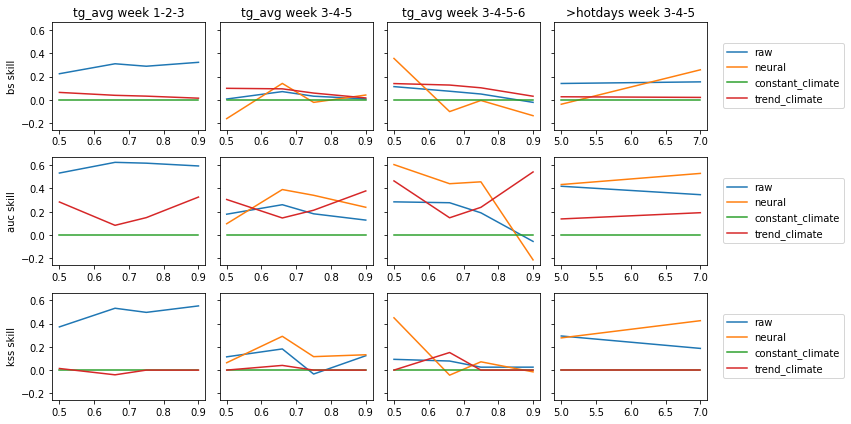

In [51]:
fig, axes = plt.subplots(nrows=3, ncols = 4, figsize = (12,6), sharey = True, facecolor='white')
aliases = pd.Series(['raw','neural','constant_climate','trend_climate'], index = ['pi','ppsf','climatology','trend'])
def plotranks(ax, plotframe):
    plotframe = plotframe.copy()
    plotframe.columns = plotframe.columns.droplevel(0)
    if not ('ppsf' in plotframe.columns):
        plotframe['ppsf'] = np.nan
    for label in aliases.index:
        ax.plot(plotframe.index, plotframe[label], label = aliases.loc[label])
    return ax
for i,score in enumerate(rankraw.columns.get_level_values('score').unique()):

    plotranks(ax = axes[i,0], plotframe = rankraw.loc[:,(score,slice(None))]) # First raw tganom 21
    plotranks(ax = axes[i,1], plotframe = ranktganom.loc[21,(score,slice(None))]) # Then pp tganom 21
    plotranks(ax = axes[i,2], plotframe = ranktganom.loc[31,(score,slice(None))]) # Then pp tganom 31
    plotranks(ax = axes[i,3], plotframe = ranktgex.loc[:,(score,slice(None))]) # Then hotdays
    #axes[i,1].plot()
    #axes[i,2].plot(ranktganom.loc[31,(score,slice(None))]) 
    #axes[i,3].plot(ranktgex.loc[:,(score,slice(None))]) # Then hotdays
    axes[i,3].legend(loc = (1.1,0.2))
    axes[i,0].set_ylabel(f'{score} skill')

axes[0,0].set_title('tg_avg week 1-2-3')
axes[0,1].set_title('tg_avg week 3-4-5')
axes[0,2].set_title('tg_avg week 3-4-5-6')
axes[0,3].set_title('>hotdays week 3-4-5')
plt.tight_layout()

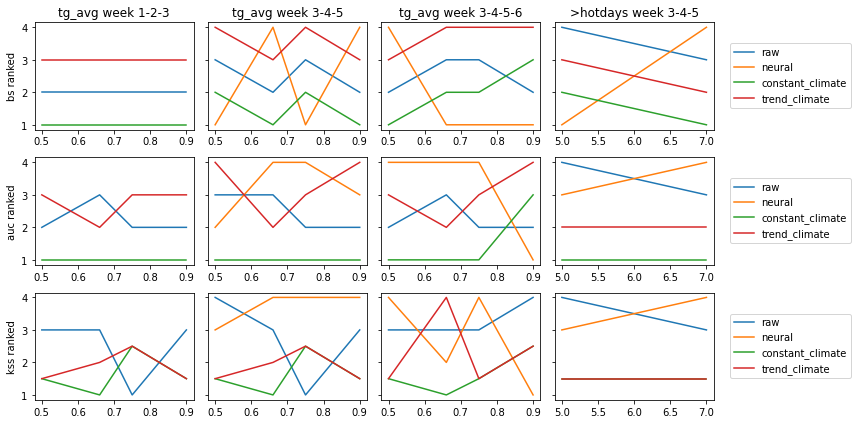

In [35]:
fig, axes = plt.subplots(nrows=3, ncols = 4, figsize = (12,6), sharey = True, facecolor='white')
aliases = pd.Series(['raw','neural','constant_climate','trend_climate'], index = ['pi','ppsf','climatology','trend'])
def plotranks(ax, plotframe):
    plotframe = plotframe.copy()
    plotframe.columns = plotframe.columns.droplevel(0)
    if not ('ppsf' in plotframe.columns):
        plotframe['ppsf'] = np.nan
    for label in aliases.index:
        ax.plot(plotframe.index, plotframe[label], label = aliases.loc[label])
    return ax
for i,score in enumerate(rankraw.columns.get_level_values('score').unique()):

    plotranks(ax = axes[i,0], plotframe = rankraw.loc[:,(score,slice(None))]) # First raw tganom 21
    plotranks(ax = axes[i,1], plotframe = ranktganom.loc[21,(score,slice(None))]) # Then pp tganom 21
    plotranks(ax = axes[i,2], plotframe = ranktganom.loc[31,(score,slice(None))]) # Then pp tganom 31
    plotranks(ax = axes[i,3], plotframe = ranktgex.loc[:,(score,slice(None))]) # Then hotdays
    #axes[i,1].plot()
    #axes[i,2].plot(ranktganom.loc[31,(score,slice(None))]) 
    #axes[i,3].plot(ranktgex.loc[:,(score,slice(None))]) # Then hotdays
    axes[i,3].legend(loc = (1.1,0.2))
    axes[i,0].set_ylabel(f'{score} ranked')

axes[0,0].set_title('tg_avg week 1-2-3')
axes[0,1].set_title('tg_avg week 3-4-5')
axes[0,2].set_title('tg_avg week 3-4-5-6')
axes[0,3].set_title('>hotdays week 3-4-5')
plt.tight_layout()